# ViT Model Inference

Load trained model and demonstrate its performance on CIFAR-10.

In [10]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import os

from src.models.mini_vit import MiniViT

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

PyTorch version: 2.9.1
CUDA available: False


## Find Latest Checkpoint

In [11]:
checkpoint_base_dir = Path('finetune/checkpoints')
checkpoint_dirs = [d for d in checkpoint_base_dir.iterdir() if d.is_dir()]

if not checkpoint_dirs:
    raise FileNotFoundError("No checkpoints found in finetune/checkpoints/")

latest_checkpoint_dir = sorted(checkpoint_dirs, key=lambda x: x.stat().st_mtime)[-1]
checkpoint_path = latest_checkpoint_dir / 'best.pt'

print(f"Using checkpoint: {latest_checkpoint_dir.name}")
print(f"Model path: {checkpoint_path}")

Using checkpoint: ep250_bs512_lr0.002_ch96_d9_h12_cls2_20260111_201216
Model path: finetune/checkpoints/ep250_bs512_lr0.002_ch96_d9_h12_cls2_20260111_201216/best.pt


## Load Model

In [12]:
checkpoint = torch.load(checkpoint_path, map_location='cpu', weights_only=False)

if 'args' in checkpoint:
    args = checkpoint['args']
    print("Model parameters from checkpoint:")
    print(f"  Channel: {args['channel']}")
    print(f"  Depth: {args['depth']}")
    print(f"  Heads: {args['heads']}")
    print(f"  MLP ratio: {args['mlp_ratio']}")
    print(f"  Num CLS tokens: {args['num_cls']}")
    print(f"  Best accuracy: {checkpoint['best_acc']:.2f}%")
    print(f"  Epoch: {checkpoint['epoch'] + 1}")
    
    model = MiniViT(
        img_size=args['img_size'],
        patch_size=args['patch_size'],
        n_classes=args['num_classes'],
        emb_dim=args['channel'],
        n_layers=args['depth'],
        n_heads=args['heads'],
        mlp_hidden_dim=args['channel'] * args['mlp_ratio'],
        num_cls=args['num_cls'],
    )
else:
    print("Model parameters (default):")
    model = MiniViT(
        img_size=32,
        patch_size=4,
        n_classes=10,
        emb_dim=96,
        n_layers=9,
        n_heads=12,
        mlp_hidden_dim=96 * 2,
        num_cls=2,
    )
    print(f"  Best accuracy: {checkpoint.get('best_acc', 'N/A')}")

model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

num_params = sum(p.numel() for p in model.parameters())
print(f"\nModel loaded. Total parameters: {num_params:,}")

Model parameters from checkpoint:
  Channel: 96
  Depth: 9
  Heads: 12
  MLP ratio: 2
  Num CLS tokens: 2
  Best accuracy: 93.50%
  Epoch: 230

Model loaded. Total parameters: 674,890


## Load CIFAR-10 Test Data

In [13]:
cifar_mean = (0.4914, 0.4822, 0.4465)
cifar_std = (0.2023, 0.1994, 0.2010)

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=cifar_mean, std=cifar_std),
])

test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=test_transform)
test_loader = DataLoader(test_dataset, batch_size=100, shuffle=False, num_workers=2)

class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 
               'dog', 'frog', 'horse', 'ship', 'truck']

print(f"Test dataset loaded: {len(test_dataset)} images")

Test dataset loaded: 10000 images


/Users/vlad/projects/vit_se_project/.venv/lib/python3.11/site-packages/torchvision/datasets/cifar.py:83: VisibleDeprecationWarning: dtype(): align should be passed as Python or NumPy boolean but got `align=0`. Did you mean to pass a tuple to create a subarray type? (Deprecated NumPy 2.4)
  entry = pickle.load(f, encoding="latin1")


## Evaluate Model on Test Set

In [14]:
def evaluate_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    all_preds = []
    all_targets = []
    
    with torch.no_grad():
        for images, targets in test_loader:
            outputs = model(images)
            _, predicted = outputs.max(1)
            
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
            
            all_preds.extend(predicted.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())
    
    accuracy = 100.0 * correct / total
    return accuracy, np.array(all_preds), np.array(all_targets)

accuracy, predictions, targets = evaluate_model(model, test_loader)
print(f"Test set accuracy: {accuracy:.2f}%")

Attention output shape: torch.Size([100, 66, 96])
Attention output shape: torch.Size([100, 66, 96])
Attention output shape: torch.Size([100, 66, 96])
Attention output shape: torch.Size([100, 66, 96])
Attention output shape: torch.Size([100, 66, 96])
Attention output shape: torch.Size([100, 66, 96])
Attention output shape: torch.Size([100, 66, 96])
Attention output shape: torch.Size([100, 66, 96])
Attention output shape: torch.Size([100, 66, 96])
Test set accuracy: 93.50%


## Prediction Visualization

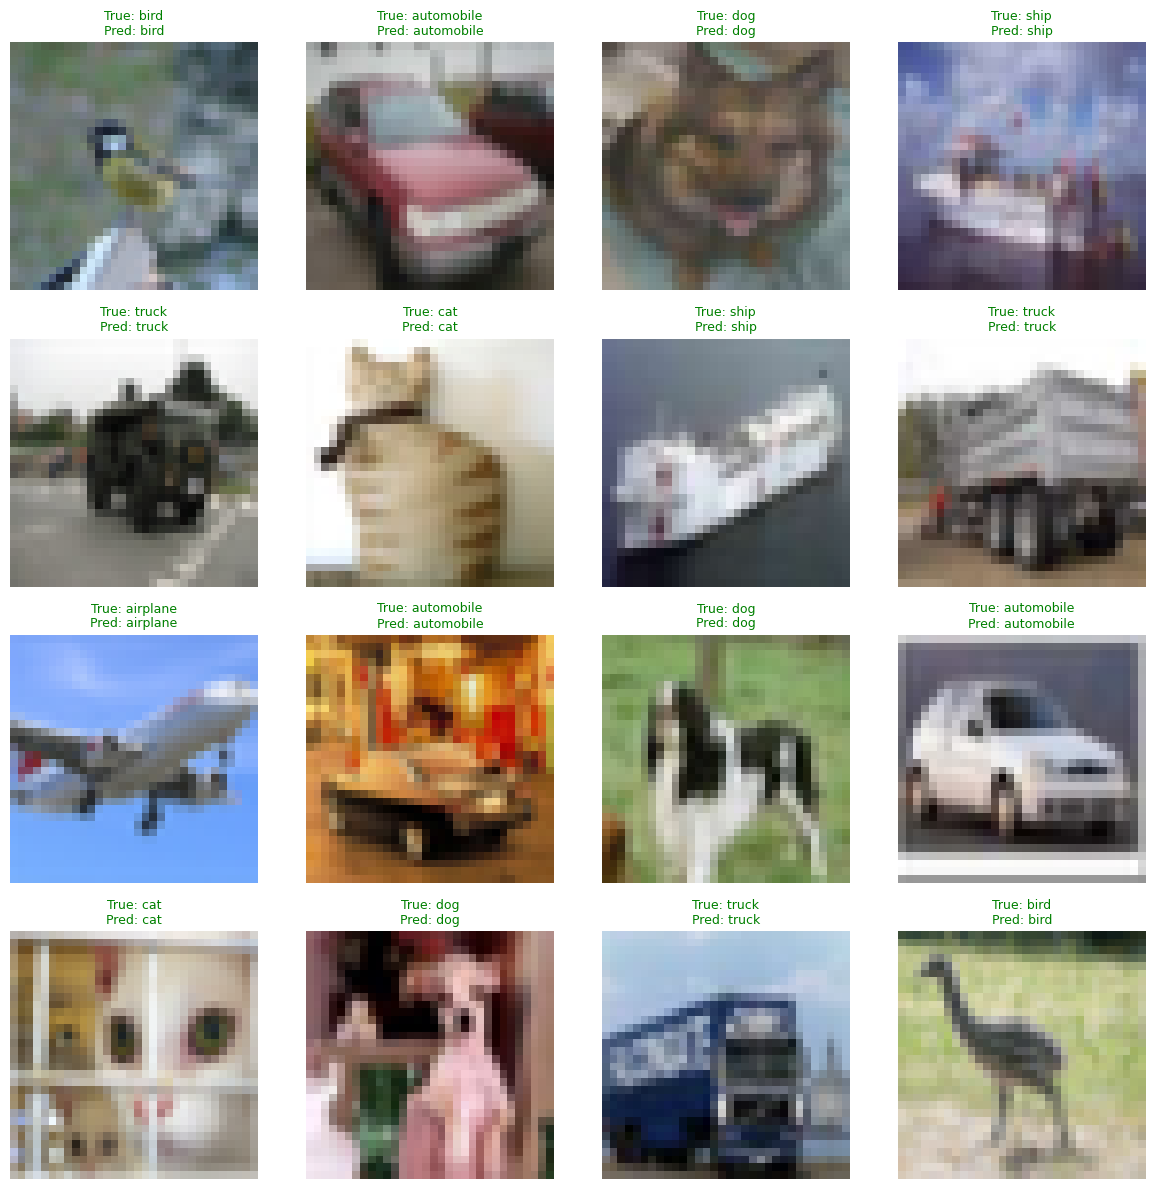

In [ ]:
def denormalize(img, mean, std):
    """Denormalize image for visualization"""
    img = img.clone()
    for i in range(3):
        img[i] = img[i] * std[i] + mean[i]
    return img

def show_predictions(model, dataset, num_images=16, seed=42):
    """Show model predictions on random images"""
    np.random.seed(seed)
    indices = np.random.choice(len(dataset), num_images, replace=False)
    
    fig, axes = plt.subplots(num_images // 4, 4, figsize=(12, 12))
    axes = axes.flatten()
    
    model.eval()
    with torch.no_grad():
        for i, idx in enumerate(indices):
            image, target = dataset[idx]
            
            output = model(image.unsqueeze(0))
            _, pred = output.max(1)
            pred_class = pred.item()
            
            img_show = denormalize(image, cifar_mean, cifar_std)
            img_show = img_show.permute(1, 2, 0).numpy()
            img_show = np.clip(img_show, 0, 1)
            
            axes[i].imshow(img_show)
            axes[i].axis('off')
            
            color = 'green' if pred_class == target else 'red'
            axes[i].set_title(f'True: {class_names[target]}\nPred: {class_names[pred_class]}', 
                            color=color, fontsize=9)
    
    plt.tight_layout()
    plt.show()

show_predictions(model, test_dataset, num_images=16)

## Confusion Matrix

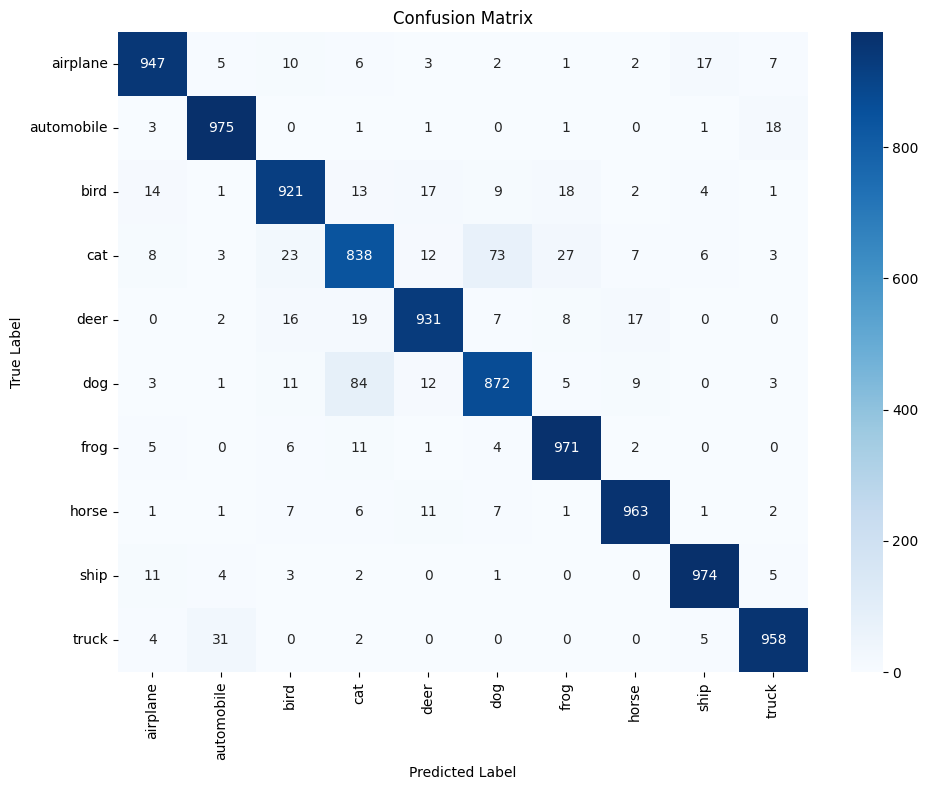


Per-class accuracy:
  airplane    : 94.70% (947/1000)
  automobile  : 97.50% (975/1000)
  bird        : 92.10% (921/1000)
  cat         : 83.80% (838/1000)
  deer        : 93.10% (931/1000)
  dog         : 87.20% (872/1000)
  frog        : 97.10% (971/1000)
  horse       : 96.30% (963/1000)
  ship        : 97.40% (974/1000)
  truck       : 95.80% (958/1000)


In [16]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(targets, predictions)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

print("\nPer-class accuracy:")
for i, class_name in enumerate(class_names):
    class_correct = cm[i, i]
    class_total = cm[i].sum()
    class_acc = 100.0 * class_correct / class_total if class_total > 0 else 0
    print(f"  {class_name:12s}: {class_acc:.2f}% ({class_correct}/{class_total})")

## Prediction Confidence Analysis

/var/folders/zj/v7pf3pz15pbd7plm2vqsvpp40000gn/T/ipykernel_13495/856093791.py:39: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([correct_conf, incorrect_conf], labels=['Correct', 'Incorrect'])


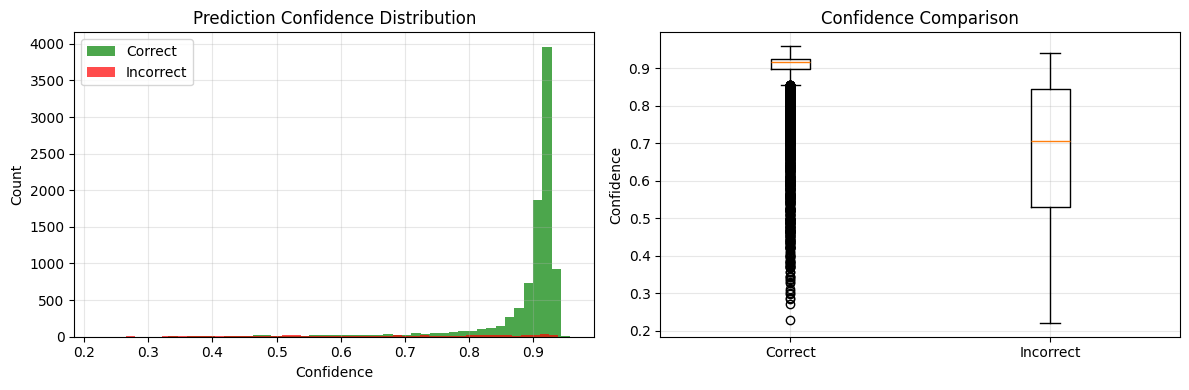


Average confidence (correct): 0.8887
Average confidence (incorrect): 0.6823


In [17]:
def analyze_confidence(model, test_loader):
    """Analyze model prediction confidence"""
    model.eval()
    all_confidences = []
    correct_confidences = []
    incorrect_confidences = []
    
    with torch.no_grad():
        for images, targets in test_loader:
            outputs = model(images)
            probs = torch.softmax(outputs, dim=1)
            confidences, predicted = probs.max(1)
            
            for conf, pred, target in zip(confidences, predicted, targets):
                conf_val = conf.item()
                all_confidences.append(conf_val)
                
                if pred == target:
                    correct_confidences.append(conf_val)
                else:
                    incorrect_confidences.append(conf_val)
    
    return all_confidences, correct_confidences, incorrect_confidences

all_conf, correct_conf, incorrect_conf = analyze_confidence(model, test_loader)

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.hist(correct_conf, bins=50, alpha=0.7, label='Correct', color='green')
plt.hist(incorrect_conf, bins=50, alpha=0.7, label='Incorrect', color='red')
plt.xlabel('Confidence')
plt.ylabel('Count')
plt.title('Prediction Confidence Distribution')
plt.legend()
plt.grid(alpha=0.3)

plt.subplot(1, 2, 2)
plt.boxplot([correct_conf, incorrect_conf], labels=['Correct', 'Incorrect'])
plt.ylabel('Confidence')
plt.title('Confidence Comparison')
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nAverage confidence (correct): {np.mean(correct_conf):.4f}")
print(f"Average confidence (incorrect): {np.mean(incorrect_conf):.4f}")

## Most and Least Confident Predictions

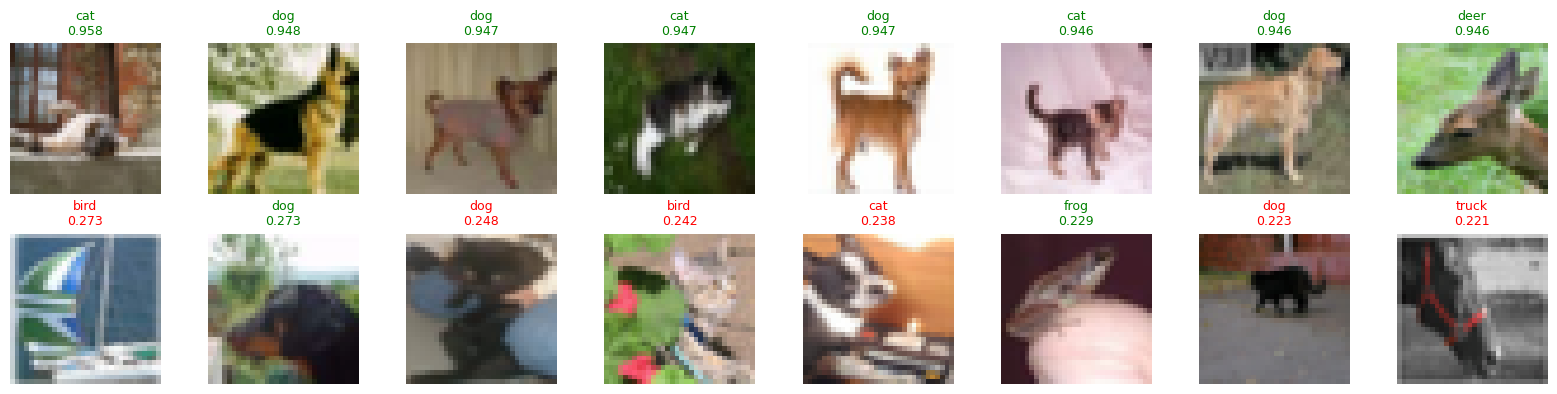

In [18]:
def show_extreme_predictions(model, dataset, num_images=8):
    """Show most and least confident predictions"""
    model.eval()
    
    predictions_data = []
    
    with torch.no_grad():
        for idx in range(len(dataset)):
            image, target = dataset[idx]
            output = model(image.unsqueeze(0))
            probs = torch.softmax(output, dim=1)
            confidence, pred = probs.max(1)
            
            predictions_data.append({
                'idx': idx,
                'confidence': confidence.item(),
                'pred': pred.item(),
                'target': target,
                'correct': pred.item() == target
            })
    
    predictions_data.sort(key=lambda x: x['confidence'], reverse=True)
    
    most_confident = predictions_data[:num_images]
    least_confident = predictions_data[-num_images:]
    
    fig, axes = plt.subplots(2, num_images, figsize=(16, 4))
    
    for i, data in enumerate(most_confident):
        idx = data['idx']
        image, target = dataset[idx]
        
        img_show = denormalize(image, cifar_mean, cifar_std)
        img_show = img_show.permute(1, 2, 0).numpy()
        img_show = np.clip(img_show, 0, 1)
        
        axes[0, i].imshow(img_show)
        axes[0, i].axis('off')
        color = 'green' if data['correct'] else 'red'
        axes[0, i].set_title(f"{class_names[data['pred']]}\n{data['confidence']:.3f}", 
                           color=color, fontsize=9)
    
    for i, data in enumerate(least_confident):
        idx = data['idx']
        image, target = dataset[idx]
        
        img_show = denormalize(image, cifar_mean, cifar_std)
        img_show = img_show.permute(1, 2, 0).numpy()
        img_show = np.clip(img_show, 0, 1)
        
        axes[1, i].imshow(img_show)
        axes[1, i].axis('off')
        color = 'green' if data['correct'] else 'red'
        axes[1, i].set_title(f"{class_names[data['pred']]}\n{data['confidence']:.3f}", 
                           color=color, fontsize=9)
    
    axes[0, 0].set_ylabel('Most\nConfident', fontsize=12, rotation=0, ha='right', va='center')
    axes[1, 0].set_ylabel('Least\nConfident', fontsize=12, rotation=0, ha='right', va='center')
    
    plt.tight_layout()
    plt.show()

show_extreme_predictions(model, test_dataset, num_images=8)